In [229]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [230]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [231]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.05#0.8
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 300
Test set size: 5700


In [232]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])

In [240]:
def get_bin_idx_and_delta(num_bins,min_bin,max_bin,raw_val):
    bin_range = (max_bin - min_bin)/num_bins
    bin_values = []
    for i in range(num_bins):
        bin_values.append(min_bin + i*bin_range + bin_range/2)
#         bin_values.append(i*bin_range+bin_range/2) # Bin values are to be in the middle of the bin
#     print("Bin range:",bin_range)
#     print("Bin centres:",bin_values)

    bin_index = np.int(np.floor((raw_val - min_bin)/bin_range))
    delta = np.float32(np.mod(raw_val,bin_range) - bin_range/2)
    
    if(bin_index >= num_bins):
        violation_distance = bin_index - (num_bins-1)
        bin_index = num_bins-1
        delta = delta + violation_distance * bin_range
    
    if(bin_index < 0):
        violation_distance = np.abs(bin_index)
        bin_index = 0
        delta = delta - violation_distance * bin_range
#     print("Bin value:",bin_values[int(bin_index)])
    return bin_index, delta

num_bins = 10
min_bin = 0
max_bin = 5
raw_val = -2.75
bin_index, delta = get_bin_idx_and_delta(num_bins,min_bin,max_bin,raw_val)
print("Raw val:",raw_val)
print("Bin index:",bin_index)
print("Delta:",delta)

Raw val: -2.75
Bin index: 0
Delta: -3.0


In [325]:
def get_value_from_bin_idx_and_delta(num_bins,min_bin,max_bin,bin_index,delta):
    bin_range = (max_bin - min_bin)/num_bins
    bin_values = []
    for i in range(num_bins):
        bin_values.append(min_bin + i*bin_range + bin_range/2) # Bin values are to be in the middle of the bin
#     print("Bin range:",bin_range)
#     print("Bin centres:",bin_values)
    
    value = np.float32(bin_values[bin_index] + delta)
    return value

num_bins = 10
min_bin = 0
max_bin = 5
value = get_value_from_bin_idx_and_delta(num_bins,min_bin,max_bin,bin_index,delta)
print(value)

-2.75


In [355]:
!python '/workspace/code/pose-prediction/src/tests/test_bin_and_delta.py' -v

0.009921399992890656
0.0033207000233232975
test_get_bin_idx_and_delta (__main__.BinAndDeltaTestCase) ... ok
test_get_value_from_bin_idx_and_delta (__main__.BinAndDeltaTestCase) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.000s

OK


In [321]:
num_bins = 8
min_bin = 0
max_bin = 4

bin_idxs = np.zeros(len(t_x_data))
deltas = np.zeros(len(t_x_data))

for i in range(len(t_x_data)):
    bin_idxs[i], deltas[i] = get_bin_idx_and_delta(num_bins,min_bin,max_bin,t_x_data[i])
# print("Raw val:",raw_val)
# print("Bin index:",bin_index)
# print("Delta:",delta)

Bin range: 0.5


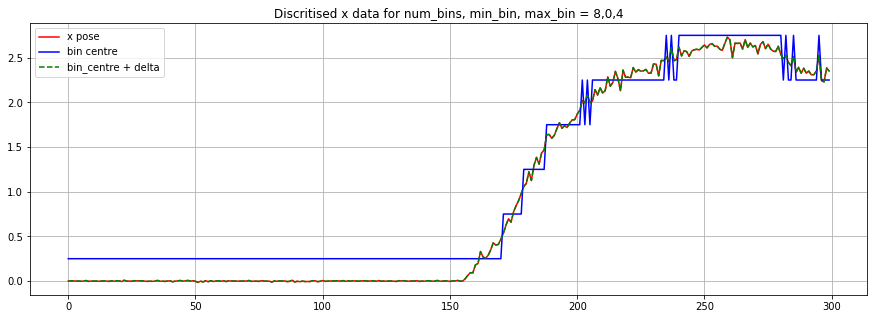

In [322]:
bin_range = (max_bin - min_bin)/num_bins
print("Bin range:",bin_range)

plt.figure(figsize=(15,5))
plt.plot(t_x_data,'r',label="x pose")
plt.plot(bin_idxs*bin_range + bin_range/2,'b',label="bin centre")
plt.plot(bin_idxs*bin_range + bin_range/2 + deltas,'g--',label="bin_centre + delta")

plt.title("Discritised x data for num_bins, min_bin, max_bin = "+str(num_bins)+","+str(min_bin)+","+str(max_bin))
plt.legend()
plt.grid()

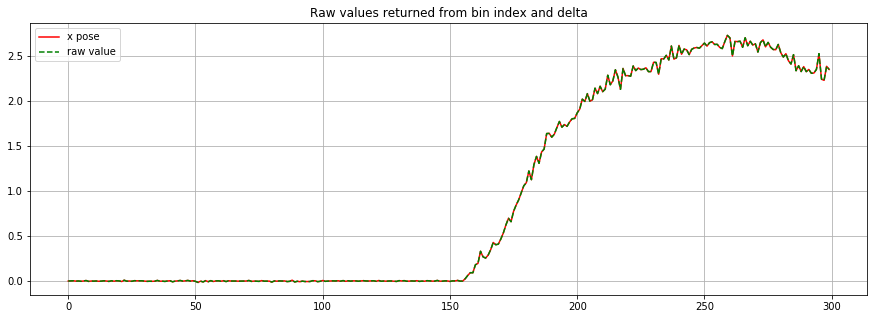

In [329]:
raw_vals = np.zeros(len(t_x_data))
for i in range(len(raw_vals)):
    raw_vals[i] = get_value_from_bin_idx_and_delta(num_bins,min_bin,max_bin,np.int(bin_idxs[i]),deltas[i])

plt.figure(figsize=(15,5))
plt.plot(t_x_data,'r',label='x pose')
plt.plot(raw_vals,'g--',label='raw value')

plt.title("Raw values returned from bin index and delta")
plt.legend()
plt.grid()